### Countermeasure (detection) in real-time

This is the development of the real-time detection, since it runs along with the attack simulation, this notebook can run independently, don't need to run the simulation one before.

In [1]:
import pybullet as p
import pybullet_data
import numpy as np
import time

p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.8)

p.loadURDF("plane.urdf")
robot = p.loadURDF("r2d2.urdf", [0, 0, 0.1])
p.loadURDF("cube.urdf", basePosition=[2, 0, 1.0])



pybullet build time: Apr 20 2025 22:34:44


2

In [2]:
num_rays = 60
ray_len = 3.0
ray_z = 1.0
origin_offset = 0.3

ray_from = []
ray_to = []
for i in range(num_rays):
    angle = 2 * np.pi * i / num_rays
    ox = origin_offset * np.cos(angle)
    oy = origin_offset * np.sin(angle)
    ray_from.append([ox, oy, ray_z])
    ray_to.append([
        ox + ray_len * np.cos(angle),
        oy + ray_len * np.sin(angle),
        ray_z
    ])

spoof_indices = range(10, 15)
window = 4
# anomaly_threshold = 0.3
local_threshold = 0.3            # Threshold for local neighbor deviation
global_threshold = 0.4           # Threshold for global deviation


In [3]:
import matplotlib.pyplot as plt

def evaluate_and_plot(hit_labels, detected_labels, hit_distances, step=None):
    """
    Evaluate detection results and plot the comparison between ground truth and detection.
    
    Args:
        hit_labels (list or np.array): Ground truth labels ("real", "spoofed", "none").
        detected_labels (list or np.array): Detection results ("detected", "OK", "none").
        hit_distances (list or np.array): LiDAR distances for the rays.
        step (int, optional): Current simulation step (for display purposes).
    """
    hit_labels = np.array(hit_labels)
    detected_labels = np.array(detected_labels)
    hit_distances = np.array(hit_distances)
    ray_indices = np.arange(len(hit_distances))

    # === Evaluation ===
    TP = sum((hit_labels == "spoofed") & (detected_labels == "detected"))
    FP = sum((hit_labels == "real") & (detected_labels == "detected"))
    FN = sum((hit_labels == "spoofed") & (detected_labels != "detected"))
    TN = sum((hit_labels == "real") & (detected_labels != "detected"))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    print("=== Evaluation Summary ===")
    print(f"True Positives  (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Negatives  (TN): {TN}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")

    # === Plotting ===
    spoofed_mask = (hit_labels == "spoofed") | (hit_labels == "sim_spoof")
    real_mask = (hit_labels == "real")
    missed_mask = (hit_labels == "none")
    detected_mask = (detected_labels == "detected")

    plt.figure(figsize=(12, 6))
    plt.plot(ray_indices, hit_distances, 'k.', alpha=0.4, label='Raw Distances')

    plt.plot(ray_indices[spoofed_mask], hit_distances[spoofed_mask] + 0.02, 
             'ro', markerfacecolor='none', label='Simulated Spoofed (Jittered)')
    plt.plot(ray_indices[detected_mask], hit_distances[detected_mask], 
             'yo', label='Detected as Spoofed')
    plt.plot(ray_indices[missed_mask], [3.0] * np.sum(missed_mask), 
             'kx', label='Missed Rays')

    plt.axhline(1.0, color='gray', linestyle='--', label='Detection Threshold')
    
    if step is not None:
        plt.title(f"Spoof Detection vs. Ground Truth (Step {step})")
    else:
        plt.title("Spoof Detection vs. Ground Truth")
    plt.xlabel("Ray Index")
    plt.ylabel("Distance (m)")
    plt.ylim(0, 3.5)
    plt.legend()
    plt.grid(True)
    plt.show()


[GREEN] Step 0 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 0 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 0 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 0 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 0 → Ray 04 missed
[GRAY] Step 0 → Ray 05 missed
[GRAY] Step 0 → Ray 06 missed
[GRAY] Step 0 → Ray 07 missed
[GRAY] Step 0 → Ray 08 missed
[GRAY] Step 0 → Ray 09 missed
[YELLOW] Step 0 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 0 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 0 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 0 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 0 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 0 → Ray 15 missed
[GRAY] Step 0 → Ray 16 missed
[GRAY] Step 0 → Ray 17 missed
[GRAY] Step 0 → Ray 18 missed
[GRAY] Step 0 → Ray 19 missed


[GREEN] Step 4 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 4 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 4 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 4 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 4 → Ray 04 missed
[GRAY] Step 4 → Ray 05 missed
[GRAY] Step 4 → Ray 06 missed
[GRAY] Step 4 → Ray 07 missed
[GRAY] Step 4 → Ray 08 missed
[GRAY] Step 4 → Ray 09 missed
[YELLOW] Step 4 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 4 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 4 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 4 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 4 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 4 → Ray 15 missed
[GRAY] Step 4 → Ray 16 missed
[GRAY] Step 4 → Ray 17 missed
[GRAY] Step 4 → Ray 18 missed
[GRAY] Step 4 → Ray 19 missed


[GREEN] Step 8 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 8 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 8 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 8 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 8 → Ray 04 missed
[GRAY] Step 8 → Ray 05 missed
[GRAY] Step 8 → Ray 06 missed
[GRAY] Step 8 → Ray 07 missed
[GRAY] Step 8 → Ray 08 missed
[GRAY] Step 8 → Ray 09 missed
[YELLOW] Step 8 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 8 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 8 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 8 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 8 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 8 → Ray 15 missed
[GRAY] Step 8 → Ray 16 missed
[GRAY] Step 8 → Ray 17 missed
[GRAY] Step 8 → Ray 18 missed
[GRAY] Step 8 → Ray 19 missed


[GREEN] Step 12 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 12 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 12 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 12 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 12 → Ray 04 missed
[GRAY] Step 12 → Ray 05 missed
[GRAY] Step 12 → Ray 06 missed
[GRAY] Step 12 → Ray 07 missed
[GRAY] Step 12 → Ray 08 missed
[GRAY] Step 12 → Ray 09 missed
[YELLOW] Step 12 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 12 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 12 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 12 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 12 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 12 → Ray 15 missed
[GRAY] Step 12 → Ray 16 missed
[GRAY] Step 12 → Ray 17 missed
[GRAY] Step 12 → Ray 18 missed
[GRAY] Step

[GREEN] Step 16 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 16 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 16 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 16 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 16 → Ray 04 missed
[GRAY] Step 16 → Ray 05 missed
[GRAY] Step 16 → Ray 06 missed
[GRAY] Step 16 → Ray 07 missed
[GRAY] Step 16 → Ray 08 missed
[GRAY] Step 16 → Ray 09 missed
[YELLOW] Step 16 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 16 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 16 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 16 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 16 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 16 → Ray 15 missed
[GRAY] Step 16 → Ray 16 missed
[GRAY] Step 16 → Ray 17 missed
[GRAY] Step 16 → Ray 18 missed
[GRAY] Step

[GREEN] Step 20 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 20 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 20 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 20 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 20 → Ray 04 missed
[GRAY] Step 20 → Ray 05 missed
[GRAY] Step 20 → Ray 06 missed
[GRAY] Step 20 → Ray 07 missed
[GRAY] Step 20 → Ray 08 missed
[GRAY] Step 20 → Ray 09 missed
[YELLOW] Step 20 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 20 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 20 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 20 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 20 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 20 → Ray 15 missed
[GRAY] Step 20 → Ray 16 missed
[GRAY] Step 20 → Ray 17 missed
[GRAY] Step 20 → Ray 18 missed
[GRAY] Step

[GREEN] Step 24 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 24 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 24 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 24 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 24 → Ray 04 missed
[GRAY] Step 24 → Ray 05 missed
[GRAY] Step 24 → Ray 06 missed
[GRAY] Step 24 → Ray 07 missed
[GRAY] Step 24 → Ray 08 missed
[GRAY] Step 24 → Ray 09 missed
[YELLOW] Step 24 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 24 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 24 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 24 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 24 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 24 → Ray 15 missed
[GRAY] Step 24 → Ray 16 missed
[GRAY] Step 24 → Ray 17 missed
[GRAY] Step 24 → Ray 18 missed
[GRAY] Step

[GREEN] Step 28 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 28 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 28 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 28 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 28 → Ray 04 missed
[GRAY] Step 28 → Ray 05 missed
[GRAY] Step 28 → Ray 06 missed
[GRAY] Step 28 → Ray 07 missed
[GRAY] Step 28 → Ray 08 missed
[GRAY] Step 28 → Ray 09 missed
[YELLOW] Step 28 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 28 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 28 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 28 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 28 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 28 → Ray 15 missed
[GRAY] Step 28 → Ray 16 missed
[GRAY] Step 28 → Ray 17 missed
[GRAY] Step 28 → Ray 18 missed
[GRAY] Step

[GREEN] Step 32 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 32 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 32 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 32 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 32 → Ray 04 missed
[GRAY] Step 32 → Ray 05 missed
[GRAY] Step 32 → Ray 06 missed
[GRAY] Step 32 → Ray 07 missed
[GRAY] Step 32 → Ray 08 missed
[GRAY] Step 32 → Ray 09 missed
[YELLOW] Step 32 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 32 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 32 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 32 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 32 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 32 → Ray 15 missed
[GRAY] Step 32 → Ray 16 missed
[GRAY] Step 32 → Ray 17 missed
[GRAY] Step 32 → Ray 18 missed
[GRAY] Step

[GREEN] Step 36 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 36 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 36 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 36 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 36 → Ray 04 missed
[GRAY] Step 36 → Ray 05 missed
[GRAY] Step 36 → Ray 06 missed
[GRAY] Step 36 → Ray 07 missed
[GRAY] Step 36 → Ray 08 missed
[GRAY] Step 36 → Ray 09 missed
[YELLOW] Step 36 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 36 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 36 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 36 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 36 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 36 → Ray 15 missed
[GRAY] Step 36 → Ray 16 missed
[GRAY] Step 36 → Ray 17 missed
[GRAY] Step 36 → Ray 18 missed
[GRAY] Step

[GREEN] Step 40 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 40 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 40 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 40 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 40 → Ray 04 missed
[GRAY] Step 40 → Ray 05 missed
[GRAY] Step 40 → Ray 06 missed
[GRAY] Step 40 → Ray 07 missed
[GRAY] Step 40 → Ray 08 missed
[GRAY] Step 40 → Ray 09 missed
[YELLOW] Step 40 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 40 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 40 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 40 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 40 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 40 → Ray 15 missed
[GRAY] Step 40 → Ray 16 missed
[GRAY] Step 40 → Ray 17 missed
[GRAY] Step 40 → Ray 18 missed
[GRAY] Step

[GREEN] Step 44 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 44 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 44 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 44 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 44 → Ray 04 missed
[GRAY] Step 44 → Ray 05 missed
[GRAY] Step 44 → Ray 06 missed
[GRAY] Step 44 → Ray 07 missed
[GRAY] Step 44 → Ray 08 missed
[GRAY] Step 44 → Ray 09 missed
[YELLOW] Step 44 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 44 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 44 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 44 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 44 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 44 → Ray 15 missed
[GRAY] Step 44 → Ray 16 missed
[GRAY] Step 44 → Ray 17 missed
[GRAY] Step 44 → Ray 18 missed
[GRAY] Step

[GREEN] Step 48 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 48 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 48 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 48 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 48 → Ray 04 missed
[GRAY] Step 48 → Ray 05 missed
[GRAY] Step 48 → Ray 06 missed
[GRAY] Step 48 → Ray 07 missed
[GRAY] Step 48 → Ray 08 missed
[GRAY] Step 48 → Ray 09 missed
[YELLOW] Step 48 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 48 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 48 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 48 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 48 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 48 → Ray 15 missed
[GRAY] Step 48 → Ray 16 missed
[GRAY] Step 48 → Ray 17 missed
[GRAY] Step 48 → Ray 18 missed
[GRAY] Step

[GREEN] Step 52 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 52 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 52 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 52 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 52 → Ray 04 missed
[GRAY] Step 52 → Ray 05 missed
[GRAY] Step 52 → Ray 06 missed
[GRAY] Step 52 → Ray 07 missed
[GRAY] Step 52 → Ray 08 missed
[GRAY] Step 52 → Ray 09 missed
[YELLOW] Step 52 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 52 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 52 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 52 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 52 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 52 → Ray 15 missed
[GRAY] Step 52 → Ray 16 missed
[GRAY] Step 52 → Ray 17 missed
[GRAY] Step 52 → Ray 18 missed
[GRAY] Step

[GREEN] Step 56 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 56 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 56 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 56 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 56 → Ray 04 missed
[GRAY] Step 56 → Ray 05 missed
[GRAY] Step 56 → Ray 06 missed
[GRAY] Step 56 → Ray 07 missed
[GRAY] Step 56 → Ray 08 missed
[GRAY] Step 56 → Ray 09 missed
[YELLOW] Step 56 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 56 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 56 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 56 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 56 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 56 → Ray 15 missed
[GRAY] Step 56 → Ray 16 missed
[GRAY] Step 56 → Ray 17 missed
[GRAY] Step 56 → Ray 18 missed
[GRAY] Step

[GREEN] Step 60 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 60 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 60 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 60 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 60 → Ray 04 missed
[GRAY] Step 60 → Ray 05 missed
[GRAY] Step 60 → Ray 06 missed
[GRAY] Step 60 → Ray 07 missed
[GRAY] Step 60 → Ray 08 missed
[GRAY] Step 60 → Ray 09 missed
[YELLOW] Step 60 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 60 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 60 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 60 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 60 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 60 → Ray 15 missed
[GRAY] Step 60 → Ray 16 missed
[GRAY] Step 60 → Ray 17 missed
[GRAY] Step 60 → Ray 18 missed
[GRAY] Step

[GREEN] Step 64 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 64 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 64 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 64 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 64 → Ray 04 missed
[GRAY] Step 64 → Ray 05 missed
[GRAY] Step 64 → Ray 06 missed
[GRAY] Step 64 → Ray 07 missed
[GRAY] Step 64 → Ray 08 missed
[GRAY] Step 64 → Ray 09 missed
[YELLOW] Step 64 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 64 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 64 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 64 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 64 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 64 → Ray 15 missed
[GRAY] Step 64 → Ray 16 missed
[GRAY] Step 64 → Ray 17 missed
[GRAY] Step 64 → Ray 18 missed
[GRAY] Step

[GREEN] Step 68 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 68 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 68 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 68 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 68 → Ray 04 missed
[GRAY] Step 68 → Ray 05 missed
[GRAY] Step 68 → Ray 06 missed
[GRAY] Step 68 → Ray 07 missed
[GRAY] Step 68 → Ray 08 missed
[GRAY] Step 68 → Ray 09 missed
[YELLOW] Step 68 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 68 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 68 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 68 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 68 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 68 → Ray 15 missed
[GRAY] Step 68 → Ray 16 missed
[GRAY] Step 68 → Ray 17 missed
[GRAY] Step 68 → Ray 18 missed
[GRAY] Step

[GREEN] Step 72 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 72 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 72 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 72 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 72 → Ray 04 missed
[GRAY] Step 72 → Ray 05 missed
[GRAY] Step 72 → Ray 06 missed
[GRAY] Step 72 → Ray 07 missed
[GRAY] Step 72 → Ray 08 missed
[GRAY] Step 72 → Ray 09 missed
[YELLOW] Step 72 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 72 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 72 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 72 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 72 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 72 → Ray 15 missed
[GRAY] Step 72 → Ray 16 missed
[GRAY] Step 72 → Ray 17 missed
[GRAY] Step 72 → Ray 18 missed
[GRAY] Step

[GREEN] Step 76 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 76 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 76 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 76 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 76 → Ray 04 missed
[GRAY] Step 76 → Ray 05 missed
[GRAY] Step 76 → Ray 06 missed
[GRAY] Step 76 → Ray 07 missed
[GRAY] Step 76 → Ray 08 missed
[GRAY] Step 76 → Ray 09 missed
[YELLOW] Step 76 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 76 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 76 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 76 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 76 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 76 → Ray 15 missed
[GRAY] Step 76 → Ray 16 missed
[GRAY] Step 76 → Ray 17 missed
[GRAY] Step 76 → Ray 18 missed
[GRAY] Step

[GREEN] Step 80 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 80 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 80 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 80 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 80 → Ray 04 missed
[GRAY] Step 80 → Ray 05 missed
[GRAY] Step 80 → Ray 06 missed
[GRAY] Step 80 → Ray 07 missed
[GRAY] Step 80 → Ray 08 missed
[GRAY] Step 80 → Ray 09 missed
[YELLOW] Step 80 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 80 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 80 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 80 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 80 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 80 → Ray 15 missed
[GRAY] Step 80 → Ray 16 missed
[GRAY] Step 80 → Ray 17 missed
[GRAY] Step 80 → Ray 18 missed
[GRAY] Step

[GREEN] Step 84 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 84 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 84 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 84 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 84 → Ray 04 missed
[GRAY] Step 84 → Ray 05 missed
[GRAY] Step 84 → Ray 06 missed
[GRAY] Step 84 → Ray 07 missed
[GRAY] Step 84 → Ray 08 missed
[GRAY] Step 84 → Ray 09 missed
[YELLOW] Step 84 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 84 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 84 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 84 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 84 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 84 → Ray 15 missed
[GRAY] Step 84 → Ray 16 missed
[GRAY] Step 84 → Ray 17 missed
[GRAY] Step 84 → Ray 18 missed
[GRAY] Step

[GREEN] Step 88 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 88 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 88 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 88 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 88 → Ray 04 missed
[GRAY] Step 88 → Ray 05 missed
[GRAY] Step 88 → Ray 06 missed
[GRAY] Step 88 → Ray 07 missed
[GRAY] Step 88 → Ray 08 missed
[GRAY] Step 88 → Ray 09 missed
[YELLOW] Step 88 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 88 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 88 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 88 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 88 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 88 → Ray 15 missed
[GRAY] Step 88 → Ray 16 missed
[GRAY] Step 88 → Ray 17 missed
[GRAY] Step 88 → Ray 18 missed
[GRAY] Step

[GREEN] Step 92 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 92 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 92 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 92 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 92 → Ray 04 missed
[GRAY] Step 92 → Ray 05 missed
[GRAY] Step 92 → Ray 06 missed
[GRAY] Step 92 → Ray 07 missed
[GRAY] Step 92 → Ray 08 missed
[GRAY] Step 92 → Ray 09 missed
[YELLOW] Step 92 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 92 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 92 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 92 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 92 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 92 → Ray 15 missed
[GRAY] Step 92 → Ray 16 missed
[GRAY] Step 92 → Ray 17 missed
[GRAY] Step 92 → Ray 18 missed
[GRAY] Step

[GREEN] Step 96 → Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Step 96 → Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Step 96 → Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Step 96 → Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Step 96 → Ray 04 missed
[GRAY] Step 96 → Ray 05 missed
[GRAY] Step 96 → Ray 06 missed
[GRAY] Step 96 → Ray 07 missed
[GRAY] Step 96 → Ray 08 missed
[GRAY] Step 96 → Ray 09 missed
[YELLOW] Step 96 → Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 96 → Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 96 → Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 96 → Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Step 96 → Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Step 96 → Ray 15 missed
[GRAY] Step 96 → Ray 16 missed
[GRAY] Step 96 → Ray 17 missed
[GRAY] Step 96 → Ray 18 missed
[GRAY] Step

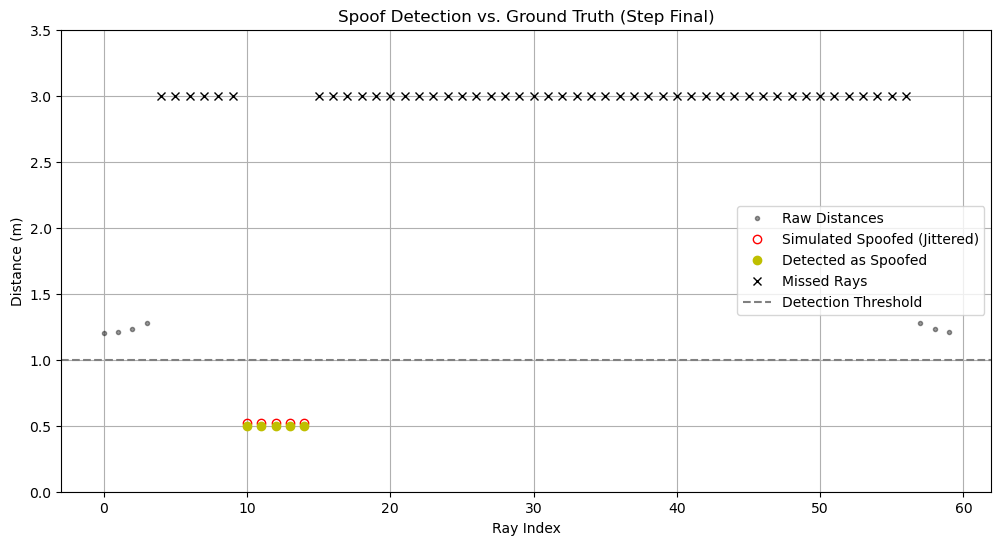

In [4]:
# ===========================
# PARAMETERS (Tune as needed)
# ===========================
window = 4                       # Local neighbor window size
local_threshold = 0.3            # Local deviation threshold
global_threshold = 0.4           # Global deviation threshold

# ===========================
# Start Detection Loop
# ===========================
for step in range(100):
    p.removeAllUserDebugItems()
    results = p.rayTestBatch(ray_from, ray_to)

    hit_distances = []
    hit_labels = []
    detected_labels = []  # ✅ RECORD DETECTION RESULTS HERE

    # === Collect ray distances and ground truth labels ===
    for i, res in enumerate(results):
        spoofed = i in spoof_indices

        if spoofed:
            angle = 2 * np.pi * i / num_rays
            hit_pos = [
                ray_from[i][0] + 0.5 * np.cos(angle),
                ray_from[i][1] + 0.5 * np.sin(angle),
                ray_z
            ]
            dist = 0.5
            hit_distances.append(dist)
            hit_labels.append("spoofed")
            color = [1, 0, 0]
        elif res[0] >= 0:
            hit_pos = res[3]
            dist = np.linalg.norm(np.array(hit_pos) - np.array(ray_from[i]))
            hit_distances.append(dist)
            hit_labels.append("real")
            color = [0, 1, 0]
        else:
            hit_pos = ray_to[i]
            hit_distances.append(-1)
            hit_labels.append("none")
            color = [0.5, 0.5, 0.5]

        p.addUserDebugLine(ray_from[i], hit_pos, color, lineWidth=1, lifeTime=1.0)

    # === Compute global trusted average ===
    global_real_hits = np.array(hit_distances)[(np.array(hit_distances) > 1.0)]
    global_avg = np.mean(global_real_hits) if len(global_real_hits) > 0 else 0

    # === Detection (local + global deviation hybrid) ===
    for i in range(num_rays):
        if hit_distances[i] > 0:  # Only process rays that hit something
            neighbors = []
            for j in range(max(0, i - window), min(num_rays, i + window + 1)):
                if j != i and hit_distances[j] > 0:
                    neighbors.append(hit_distances[j])

            # Fallback to global average if not enough neighbors
            local_avg = np.mean(neighbors) if len(neighbors) >= 2 else global_avg

            # Calculate deviations
            local_dev = abs(hit_distances[i] - local_avg)
            global_dev = abs(hit_distances[i] - global_avg)

            # Detection decision
            if (local_dev > local_threshold) or (global_dev > global_threshold):
                detected_labels.append("detected")  # Record detection result
                print(f"[YELLOW] Step {step} → Ray {i:02d} flagged as spoofed (local dev = {local_dev:.2f}, global dev = {global_dev:.2f})")
                p.addUserDebugLine(ray_from[i], ray_to[i], [1, 1, 0], lineWidth=3, lifeTime=1.0)
            else:
                detected_labels.append("OK")        # Record not detected
                print(f"[GREEN] Step {step} → Ray {i:02d} OK (local dev = {local_dev:.2f}, global dev = {global_dev:.2f})")
        else:
            detected_labels.append("none")         # For missed rays
            print(f"[GRAY] Step {step} → Ray {i:02d} missed")

# ===========================
# Evaluation and Plotting (runs after the loop)
# ===========================
evaluate_and_plot(hit_labels, detected_labels, hit_distances, step="Final")
